In [1]:
import torch
import torch.nn as nn 
from torchinfo import summary

In [2]:
# 定义VGGNet的网络结构
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        # 将提取的特征输入网络，后面有专门解释这部分的内容
        self.features = features
        # 定义全连接层
        self.classifier = nn.Sequential(
            # 全连接层+ReLU+Dropout
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # 全连接层+ReLU+Dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # 全连接层
            nn.Linear(4096, num_classes),
        )

    # 定义前向传播函数
    def forward(self, x):
        # 先经过feature提取特征，flatten后送入全连接层
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
# 定义相关配置项，其中M表示池化层，数值完全对应论文中的表格数值
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# 根据传入的配置项拼接卷积层
def make_layers(cfg):
    layers = []
    in_channels = 3 #初始通道数为3
    # 遍历传入的配置项
    for v in cfg:
        if v == 'M': # 如果是池化层，则直接添加MaxPool2d即可
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else: # 如果是卷积层，则添加3x3卷积+ReLU
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v #记录通道数，作为下一次的in_channels
    # 返回使用Sequential包装的卷积层
    return nn.Sequential(*layers)

In [7]:
# 封装函数，依次传入对应配置项
def vgg11(num_classes=1000):
    return VGG(make_layers(cfgs['vgg11']), num_classes=num_classes)

def vgg13(num_classes=1000):
    return VGG(make_layers(cfgs['vgg13']), num_classes=num_classes)

def vgg16(num_classes=1000):
    return VGG(make_layers(cfgs['vgg16']), num_classes=num_classes)

def vgg19(num_classes=1000):
    return VGG(make_layers(cfgs['vgg19']), num_classes=num_classes)

# 查看模型结构及参数量，input_size表示示例输入数据的维度信息
summary(vgg16(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [14]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = vgg11(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30),  # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)),  # 随机裁剪调整大小进行resize
    transforms.RandomHorizontalFlip(p = 0.5),  # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5),  # 随机垂直翻转
    transforms.ToTensor(),  # 将图片转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test集的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test",
                                    download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10, pin_memory=True)

# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train",
                                   download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=10, pin_memory=True)

In [15]:
# 设置epoch数并开始训练
num_epochs = 200  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

In [16]:
import sys 

In [17]:
# tqdm用于显示进度条并评估在每时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
        
        '''
        # 测试模型，不计算梯度
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        
        # 记录训练集损失和测试集准确率
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        '''
        
    # 打印中间值
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

Epoch: 0 Loss: 2.354295585982728 Acc: 0.00980392156862745                       
Epoch: 5 Loss: 2.332350460862069 Acc: 0.012745098039215686                      
Epoch: 10 Loss: 2.3063503580737676 Acc: 0.024509803921568627                    
Epoch: 15 Loss: 2.28418815936853 Acc: 0.01764705882352941                       
Epoch: 20 Loss: 2.2729688298662434 Acc: 0.041176470588235294                    
Epoch: 25 Loss: 2.2355197124124047 Acc: 0.061764705882352944                    
Epoch: 30 Loss: 2.216440815823847 Acc: 0.07450980392156863                      
Epoch: 35 Loss: 2.1941167069108287 Acc: 0.1303921568627451                      
Epoch: 40 Loss: 2.1684533883132824 Acc: 0.15098039215686274                     
Epoch: 45 Loss: 2.142684098269669 Acc: 0.2                                      
Epoch: 50 Loss: 2.121996153394914 Acc: 0.21764705882352942                      
Epoch: 55 Loss: 2.091639848795923 Acc: 0.257843137254902                        
Epoch: 60 Loss: 2.0630911663

KeyboardInterrupt: 

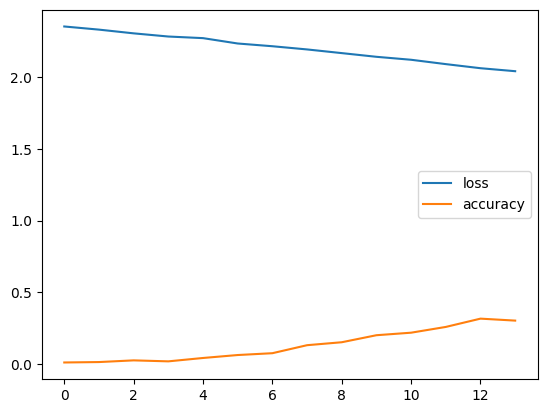

Accuracy: 0.30196078431372547


In [18]:
# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

print("Accuracy:",acc_history[-1])

In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.005)